# Lineare zeitinvariante Systeme
## Versuch 4, Praktikum Technische Grundlagen der künstlichen Intelligenz

In diesem Versuch geht es um lineare zeitinvariante Systeme: in Teil 1 führen wir eine Systemidentifikation anhand eines simulierten Schwingkreises durch, in Teil 2 benutzen wir FFT-Filter zum Aufbau einer digitalen Frequenzweiche.

### 1. Simulation eines RLC-Reihenschwingkreises
Ein Reihenschwingkreis besteht aus den drei Elementen: ohmscher Widerstand R, Kapazität C und Induktivität L, die in Reihe angeordnet sind.

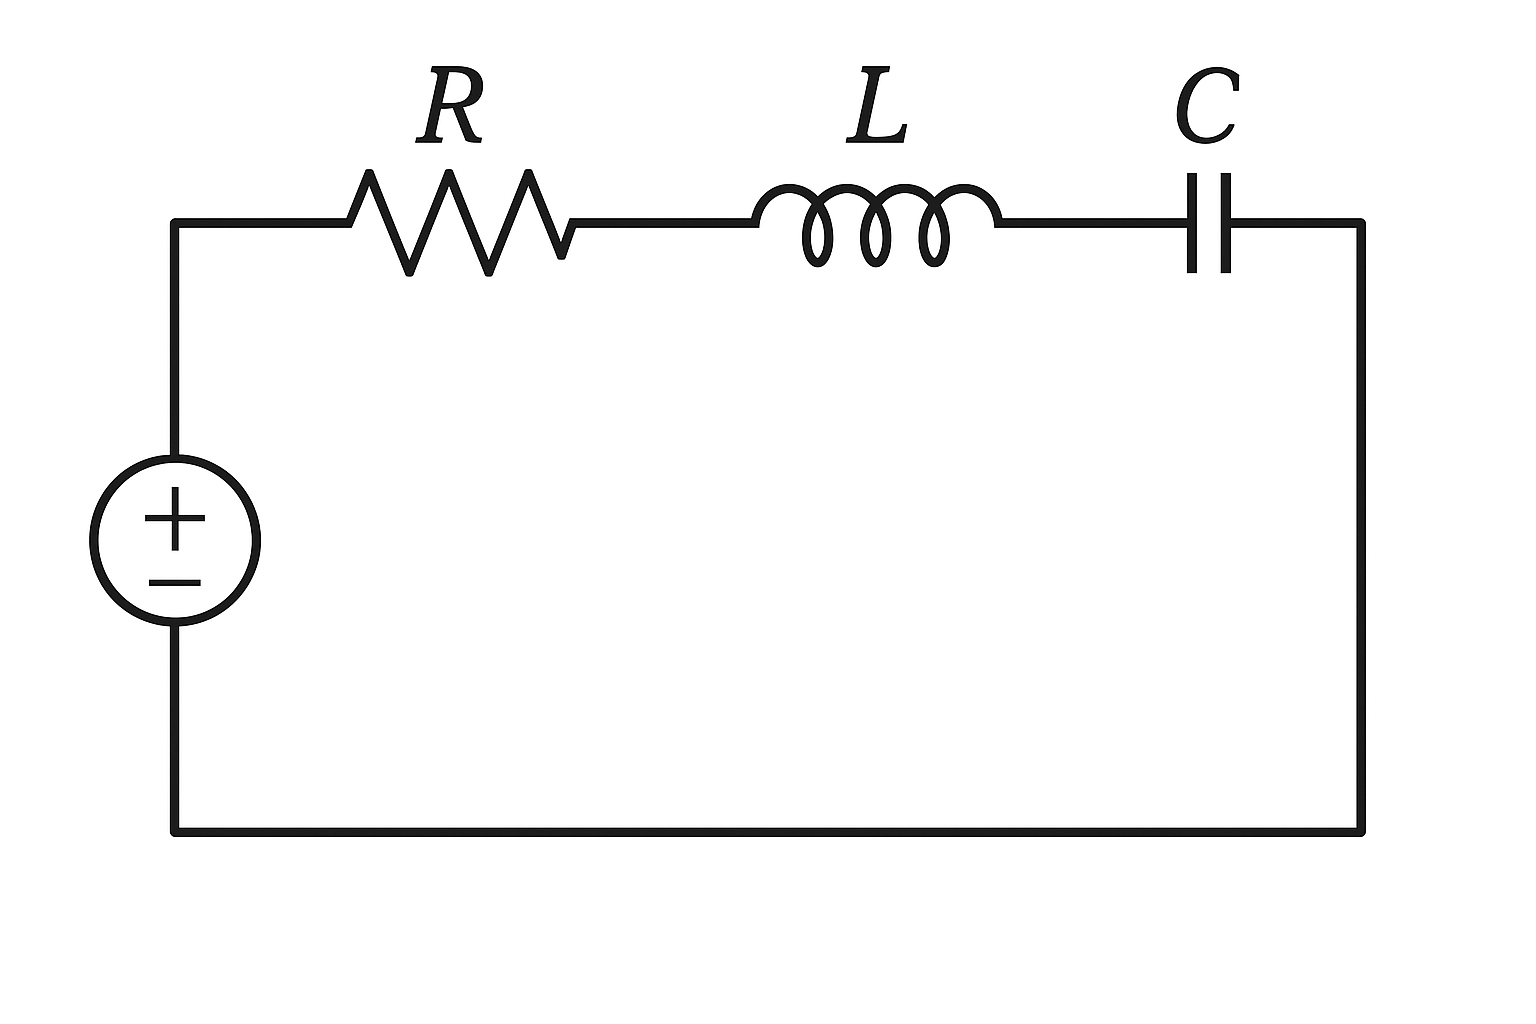

Das Eingangssignal ist eine zeitveränderliche Spannung, die im Schaltbild als +/-Symbol dargestellt ist. Das Ausgangsignal ist die Spannung, die am Kondensator abfällt, und wird entsprechend an den beiden Kondensatoranschlüssen hinausgeführt bzw. gemessen. Typische Anwendungsfälle solcher Schwingkreise sind als Oszillatoren oder Filter im Radio- und Funkbereich.

Der folgende Code simuliert einen solchen Schwingkreis für eine Zeitdauer von 10 ms, wobei das Eingangssignal in der Funktion *input_voltage(t)* definiert ist:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.fft import fft, ifft
import math

In [6]:
# Zeitveränderliche Eingangsspannung (hier eine Rechteckschwingung, 
# bitte nachher modifizieren!)
def input_voltage(t):
    # Example: Square wave with 1V amplitude, 1kHz frequency
    return 1.0 if (t % 0.001) < 0.0005 else 0.0

In [4]:
# Parameter des Schaltkreises
R = 1000  # Widerstand (Ω)
L = 50e-2  # Induktivität (500 mH)
C = 0.2e-6  # Kapazität (0.1 μF)

# Schaltkreismodell
def rlc_ode(t, state):
    v_c, i_L = state
    dvdt = i_L / C
    didt = (input_voltage(t) - R*i_L - v_c) / L
    return [dvdt, didt]

# Simulation
t_span = [0, 0.01]  # 10 ms simulation
t_eval = np.linspace(*t_span, 1000)
initial_state = [0, 0]  # [Initial capacitor voltage, Initial inductor current]
solution = solve_ivp(rlc_ode, t_span, initial_state, t_eval=t_eval)

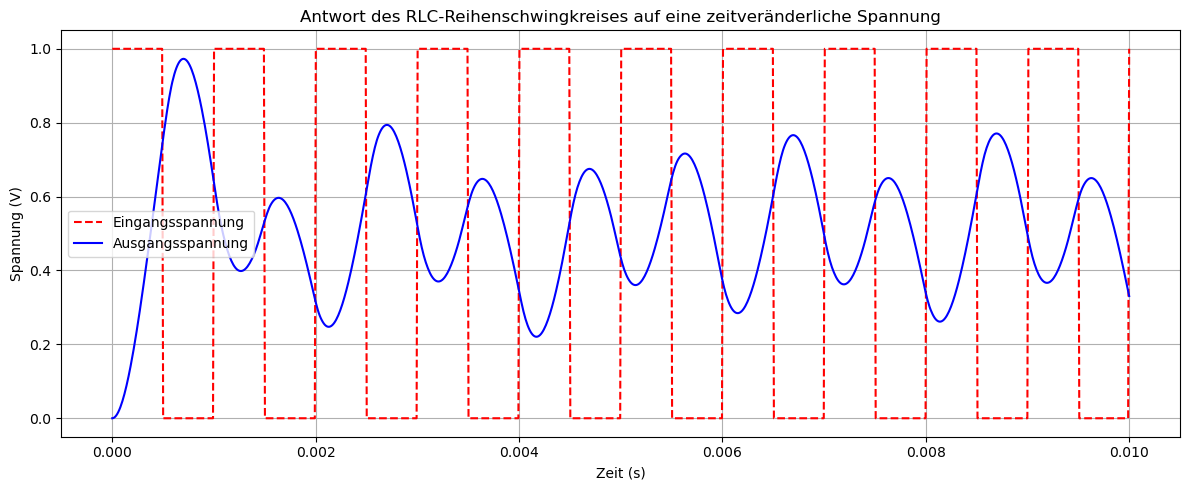

In [8]:
# Plot
plt.figure(figsize=(12, 5))

# Eingangsspannung
plt.plot(solution.t, [input_voltage(t) for t in solution.t], 'r--', 
         label='Eingangsspannung')
plt.ylabel('Spannung (V)')
plt.title('Antwort des RLC-Reihenschwingkreises auf eine zeitveränderliche Spannung')
plt.xlabel('Zeit (s)')

# Ausgangsspannung
plt.plot(solution.t, solution.y[0], 'b-', label='Ausgangsspannung')
plt.legend()
plt.grid(True)

plt.tight_layout()

### 2. Teil 1: Systemidentifikation
Der RLC-Reigenschwingkreis ist ein zeitinvariantes lineares System. Ihre erste Aufgabe ist es, den Frequenzgang dieses Systems zu ermitteln. Wenden Sie dazu die Methode aus Vorlesung 11, Folie 18 bis 22 an: 

1. Als Eingangssignal programmieren Sie in *input_voltage(t)* eine Sprungfunktion von 0 auf 1 Volt, wobei der Sprung innerhalb der ersten 2 ms erfolgen sollte, damit die ganze Sprungantwort in die 10 ms Simulationszeit passt.
2. Simulieren Sie mit dem oben angegebenen Code die Sprungantwort des Schwingkreises.
3. Erzeugen Sie daraus die Impulsantwort des Schwingkreises durch numerische Differentation (z.B. mit *numpy.gradient*). Für die Weiterverarbeitung behalten Sie nur den Teil der Impulsantwort bei, der nach dem Sprung erfolgt.
4. Berechnen Sie die quadrierte Impulsantwort und integrieren diese dann auf, d.h. für die Impulsantwort $h[n]$ berechnen Sie deren Signalenergie
$$ E = \Delta t \sum_{n=0}^{N-1} h^2[n] $$
mit dem Abtastintervall $\Delta t$ und Anzahl der Datenpunkte $N$.
6. Durch Multiplikation der Impulsantwort mit dem Faktor $1/\sqrt{E}$ erhalten Sie die *normierte Impulsantwort*, die auf einen Eingangsimpuls der Höhe 1 entstehen würde.
7. Berechnen Sie die Fouriertransformierte der normierten Impulsantwort mit dem Vorfaktor $1/N$, um den Frequenzgang zu erhalten.
8. Stellen Sie den Frequenzgang als ein Bode-Diagramm dar.
9. Bestimmen Sie die Resonanzfrequenz des Schwingkreises (Maximum des Amplitudengangs). Überprüfen Sie die Plausibilität anhand des theoretisch vorhergesagten Wertes
$$ f_\text{res} = \frac{1}{2\pi\sqrt{LC}} $$
mit der Induktivität $L$ und der Kapazität $C$ des Schwingkreises (s. Simulationscode).

In [9]:
# ab hier Ihre Lösung für Teil 1

### Teil 2: Digitale Frequenzweiche mit FFT-Filtern
Eine Frequenzweiche teilt ein Audiosignal auf mehrere Lautsprecher in Abhängigkeit von der Tonhöhe (Frequenz) auf. Hochwertige Lautsprecher wie Hochtonlautsprecher und Tieftonlautsprecher sind konstruktiv bedingt nur für einen engen Frequenzbereich optimiert. Die Kombination mehrerer unterschiedlicher Lautsprechertypen in Lautsprecherboxen für verschiedene Frequenzbereiche benötigt entsprechende Frequenzweichen.

In Teil 2 implementieren wir eine digitale Frequenzweiche mit FFT-Filtern. Als Beispiel können Sie einen zehnsekündigen Ausschnitt aus einem Musikstück Ihrer Wahl verwenden, das natürlich ein möglichst breites Tonspektrum aufweisen sollte. Wir verwenden zum Einlesen und Analysieren der Soundfiles das Paket *librosa*, das Sie natürlich auf Ihrem System installieren müssen. Beispiele zur Anwendung von *librosa* finden Sie im zweiten Teil des Notebooks zur Vorlesung 9.

Vorgehensweise:
1. Lesen Sie Ihr Musikstück mit *librosa* ein und ermittlen Sie die Abtrastrate. Wählen Sie einen geeigneten 10s-Ausschnitt und stellen Sie diesen als Kurve und als Spektrogramm dar.
2. Zerlegen Sie Ihr Signal in Blöcke der Länge 1024.
3. Tieftöner haben typischerweise einen Frequenzbereich von 30 Hz – 600 Hz, Mitteltöner 300 Hz – 5.000 Hz und Hochtöner 2.000 Hz – 20.000 Hz. Wählen Sie eine geeignete Grenzfrequenz für einen Tiefpass zur Ansteuerung des Tieftöners und für einen Hochpass zur Ansteuerung des Hochtöners und rechnen Sie diese in die zugehörige Wellenzahl um. Der Bandpass zur Ansteuerung des Mitteltöners liegt folglich zwischen diesen beiden Grenzfrequenzen.
4. Implementieren drei FFT-Filter: (1) einen idealen Tiefpass; (2) einen idealen Bandpass; (3) einen idealen Hochpass. Dies geschieht durch einfaches Nullsetzen aller Frequenzen im Sperrbereich und Beibehaltung des Spektrums im Durchlassbereich für jeden 1024er-Block. Achten Sie darauf, dass das FFT-Spektrum spiegelsymmetrisch ist, d.h. z.B. bei einem Hochpass müssen Sie das Spektrum für alle Frequenzen von 0 bis zur Grenzwellenzahl $k$ auf Null setzen, aber auch für alle Frequenzen von $N-k$ bis $N-1$.
5. Filtern Sie Ihr Signal mit allen drei Filtern und stellen das Ergebnis als Spektrogramme dar.
6. Überprüfen Sie Ergebnis akustisch durch Abspielen mit *IPython.display.Audio*.

In [10]:
# ab hier Ihre Lösung für Teil 2